In [1]:
import os
path_folder=r'C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi'
os.chdir(path_folder)

In [2]:
import datetime as datetime
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import cm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
from yahoo_fin.options import get_options_chain, get_expiration_dates

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import pickle
import pytz
import scipy
import scipy.stats as st
import warnings

vec_bsinv = np.vectorize(bsinv)
% matplotlib inline

UsageError: Line magic function `%` not found.


In [10]:
def forward_price(spot, div, r, tau):
    """
    Input:
    spot = Spot Price
    div = sum of dividends to be paid until expiration of option contract at T
    r = Risk free rate
    tau = Time to Expiration (can be single number or array)
    
    Output:
    Forward Price F
    
    Computes the forward price, allows for single or array input
    """
    
    F = spot*np.exp(r*tau) - div*np.exp(r*tau)
    return F

In [3]:
def rbergomi_s(forward, strikes, texp, params):
    
    """
    Input: 
    forward = Forward Price
    strikes = Set of Strike prices for one(!) expiration
    texp = Time to Expiration
    params = rBergomi Parameters
    
    Output:
    rBivs = rBergomi IVs
    call_prices = rBergomi computed call prices
    rB = rBergomi model object
    FT = 20.000 Forward Price adjusted price realizations at T
    
    This function is able to compute the rBergomi IVs and other values for a single(!)
    expiration
    
    """
    
    alpha, eta, rho, xi = params
    
    # to ensure computation works, we have to give greater granularity for very short durations.
    if texp < 0.01:
        steps_year = 100000
    else:
        steps_year = 366

    # Defining the Fractional Brownian Process and Resulting Price Process
    np.random.seed(4)
    rB = rBergomi(n = steps_year, N = 20000, T = texp, a = alpha)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = xi, eta = eta)
    S = rB.S(V, dB)
    
    # rBergomi Implied Volatilities and Call Prices
    ST = S[:,-1][:,np.newaxis]
    FT = ST*forward
    K = strikes #np.exp(strikes) #(np.exp(k)*spot)[np.newaxis,:]
    call_payoffs = np.maximum(FT - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    rBivs = vec_bsinv(call_prices, forward, np.transpose([K]), rB.T)
    return rBivs, call_prices, rB, FT

In [4]:
def calculating_expiration(file_name, expiration_dates, loaded_dictionary):
    """
    Input:
    file_name = file name of loaded option data in pickle format
    expiration_dates = extracted dates of maturities for option data 
    loaded_dictionary = all available option data
    
    Output:
    df_all_maturities = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Calculating all expirations of option chain in years and 
    combining all information into one DataFrame!
    """
    
    # Time of File
    date_str = file_name[17:-4]
    str_format1 = "%Y-%m-%d"
    t_datetime = datetime.datetime.strptime(date_str, str_format1)


    df_all_maturities = pd.DataFrame()
    for i, val in enumerate(expiration_dates):

        # Time To Expiration
        str_format2 = "%B %d, %Y"
        exp_datetime = datetime.datetime.strptime(val, str_format2)

        # Calculating Time to Expiration in Years
        totsec = (exp_datetime - t_datetime).total_seconds()
        years = totsec / 3600 / 24 / 365
        tau = np.round(years, 3)
        
        # Storing all info in the dataframe
        df_maturity_t = loaded_dictionary[val]["calls"]
        df_maturity_t["Maturity"] = val
        df_maturity_t["Tau"] = tau
        df_all_maturities = pd.concat([df_all_maturities, df_maturity_t])
    return df_all_maturities, t_datetime

def clean_contracts(df, t_datetime):
    """
    Input:
    df = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Output:
    df_clean = dataframe of cleaned data by liquidity and time of last trade
    df_unclean = dataframe with both liquid (clean) and illiquid (unclean) data
    
    Cleans the observed contracts according to liquidity and time of last price
    
    """
    
    df2 = df.copy()
    
    str_format2 = "%B %d, %Y"
    exp_datetime_list = [datetime.datetime.strptime(x, str_format2) for x in df2["Maturity"].values]
    
    # calculate needed data
    mid = (df2["Ask"] + df2["Bid"])/2
    spread = df2["Ask"] - df2["Bid"]
    liquidity = spread/mid
    df2["Mid"] = mid
    df2["Spread"] = spread
    df2["Liquidity"] = liquidity
    df2["Keep"] = True
    
    # Calculate forward price for all contracts
    fwd_list = forward_price(spot, div, r, df2["Tau"])
    df2.loc[:, "Fwd"] = fwd_list
    
    # Transform the reported IVs into usable float format
    yahoo_ivs = [np.float(x.split("%")[0])*0.01 for x in df2["Implied Volatility"].values]
    df2.loc[:, "Implied Volatility"] = yahoo_ivs
    
    # Translate reported date into python timestamp
    dt_str_list = [x.split(" ")[0] for x in df2["Last Trade Date"]]
    listasts = pd.DatetimeIndex(dt_str_list)
    df2["Last Trade Date"] = listasts
    df2 = df2.reset_index(drop=True)
    
    # Iterate through the df
    for index, row in df2.iterrows():

        # Identify too old trades/quotes
        date = row["Last Trade Date"]
        lasttrade_delta = (t_datetime - date).days
        if lasttrade_delta >= 1: # if last trade is older than 1 day

            delta_percent = lasttrade_delta/(exp_datetime_list[index] - date).days
            #print("need to check: ", lasttrade_delta)
            #print("delta: ", delta_percent)
            if delta_percent > 0.05:
                keep_var = False
            else:
                keep_var = True

        else:
            keep_var = True
            
        if keep_var == True:
            # Identify illiquid option contracts, for all that have been traded recently
            
            liquidity_i = row["Liquidity"]
            #print(liquidity_i)
            #print("liquidity: ", liquidity_i)
            if liquidity_i > 0.05 or liquidity_i < 0:
                keep_var = False
                #print("Keep?", keep_var)
            else:
                keep_var = True
                
            #print(liquidity_i, keep_var)
        df2.loc[index,"Keep"] = keep_var
        

    df_unclean = df2
    #display(df_clean_test)

    df_clean = df_unclean[df_unclean["Keep"]==True]
    #display(df_clean_test) 
    
    cleaned_num = len(df) - len(df_clean)
    print("Number of deleted contracts: ", cleaned_num)
    return df_clean, df_unclean

In [5]:
file_name =  "optionsData_AAPL_2021-06-25.pkl" #"optionsData_AAPL_2021-05-05.pkl"
# Time of File
date_str = file_name[17:-4]
str_format1 = "%Y-%m-%d"
t_datetime = datetime.datetime.strptime(date_str, str_format1)

ticker_str = file_name[12:16]
file_to_read = open(file_name, "rb")
loaded_dictionary = pickle.load(file_to_read)
expiration_dates = [key for key in loaded_dictionary]

In [6]:
# Download Discount Rate for black scholes models
start = dt(2010, 1, 1)
end = dt.today()
# DFF = https://fred.stlouisfed.org/series/DFF
# Effective federal funds rate
eff = web.DataReader("DFF", "fred", start, end) # in percent
r = eff.loc[date_str].DFF * 0.01 # in decimal places

In [7]:
# Dividend
div = 0

# Spot price
spot = 133.11

In [11]:
"""
Here we calculate 
- the dataframe of only illiquid contracts
- BID/ASK/MID IVs
- Log Strike
- Log Moneyness

"""


# Combining all contracts for all maturities into one df
df_all_maturities, t_datetime = calculating_expiration(file_name, expiration_dates, loaded_dictionary)
# Cleaning the contracts
df_cleaned, df_uncleaned = clean_contracts(df_all_maturities, t_datetime)
# Dataframe of discarded option contracts
df_not_clean = df_uncleaned[~df_uncleaned.apply(tuple,1).isin(df_cleaned.apply(tuple,1))]

# As python is not able to compute the IVs within the functions above (potential bug?)
# we simply add those here:

# Finding BID/ASK/MID IVs for all contracts
bid_iv_vals = vec_bsinv(df_cleaned["Bid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
ask_iv_vals = vec_bsinv(df_cleaned["Ask"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
mid_iv_vals = vec_bsinv(df_cleaned["Mid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])

df_cleaned.loc[:, "Bid IVs"] = bid_iv_vals
df_cleaned.loc[:, "Ask IVs"] = ask_iv_vals
df_cleaned.loc[:, "Mid IVs"] = mid_iv_vals

# ------------------- This step is to take the yahoo reported IVs, whenever the MID IVs report erroneous values --------------------------------------------
mid_vols = df_cleaned["Mid IVs"].values
# This is a 1D array of true/false values given the condition at the end
condition=np.mod(mid_vols, 1)==1e-19
#this extracts the values from yahooivs, where mid-vols are close to zero
extractedvals = np.extract(condition, df_cleaned["Implied Volatility"].values)
# this inserts the yahoo ivs, in case the mid vols are close to zero in the correct position
np.place(mid_vols, mid_vols == 1e-19, extractedvals)

df_cleaned["Mid IVs"] = mid_vols
# ----------------------------------------------------------------------------------------------------------------------------------------------------------



# set log-strike column
log_strike = np.log(df_cleaned["Strike"]/df_cleaned["Fwd"])
df_cleaned.loc[:, "Log Strike"] = log_strike

# set log-moneyness column
log_moneyness = np.log(df_cleaned["Fwd"]/df_cleaned["Strike"])
df_cleaned.loc[:, "Log Moneyness"] = log_moneyness

Number of deleted contracts:  464


C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-11-c38a89d4e9a1>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [12]:
# Singling out the option chain based on maturity with longest time to maturity
df_last_mat = df_cleaned[df_cleaned["Tau"]==1.975]
df_last_mat.iloc[:,5:]

,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,Mid,Spread,Liquidity,Keep,Fwd,Bid IVs,Ask IVs,Mid IVs,Log Strike,Log Moneyness
921,74.35,-0.77,-1.03%,8,2218,0.3696,"June 16, 2023",1.975,74.150,0.40,0.005394,True,133.373152,0.317892,0.352443,0.336415,-0.798806,0.798806
922,69.70,-0.6,-0.85%,11,1616,0.3574,"June 16, 2023",1.975,69.500,0.40,0.005755,True,133.373152,0.317706,0.343744,0.331322,-0.718764,0.718764
923,65.15,-0.25,-0.38%,6,440,0.3473,"June 16, 2023",1.975,64.950,0.40,0.006159,True,133.373152,0.315920,0.336313,0.326423,-0.644656,0.644656
924,60.75,-0.36,-0.59%,7,462,0.3401,"June 16, 2023",1.975,60.525,0.45,0.007435,True,133.373152,0.312712,0.331213,0.322171,-0.575663,0.575663
925,56.40,0,-,3,798,0.3312,"June 16, 2023",1.975,56.175,0.45,0.008011,True,133.373152,0.308315,0.323762,0.316159,-0.511124,0.511124
926,52.20,-0.55,-1.05%,4,403,0.3238,"June 16, 2023",1.975,51.975,0.45,0.008658,True,133.373152,0.304417,0.317552,0.311055,-0.450500,0.450500
927,48.10,-0.32,-0.67%,3,586,0.3160,"June 16, 2023",1.975,47.900,0.40,0.008351,True,133.373152,0.300544,0.310680,0.305645,-0.393341,0.393341
928,44.25,-0.3,-0.67%,5,225,0.3111,"June 16, 2023",1.975,44.050,0.40,0.009081,True,133.373152,0.297603,0.306525,0.302083,-0.339274,0.339274
929,40.65,-0.4,-0.99%,29,8033,0.3081,"June 16, 2023",1.975,40.450,0.40,0.009889,True,133.373152,0.296137,0.304112,0.300136,-0.287981,0.287981
930,37.10,-0.45,-1.20%,102,603,0.3027,"June 16, 2023",1.975,36.900,0.40,0.010840,True,133.373152,0.291988,0.299259,0.295630,-0.239191,0.239191


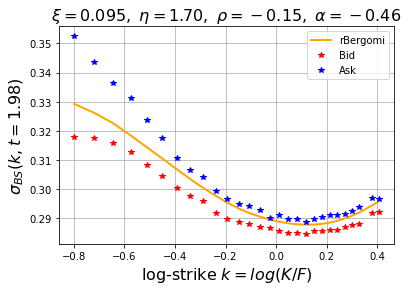

In [13]:
"""
Here we want to calibrate manually to the selected option chain above

"""

# Standard Parameters
#T = 1.0
a = -0.43
eta = 1.9
rho = -0.9
xi = 0.235**2


# Manual Calibrated Parameters for Fractional Brownian Process
# 26.06.2021
a_2 = -0.46
eta_2 = 1.7
rho_2 = -0.15
xi_2 = 0.309**2


params = a, eta, rho, xi
params_2 = a_2, eta_2, rho_2, xi_2
#rBivs, c0, rB, FT = rbergomi_s(forward, strike, tau, params)
rBivs, c0, rB, FT = rbergomi_s(df_last_mat["Fwd"].iloc[0], df_last_mat["Strike"].values, df_last_mat["Tau"].iloc[0], params_2)


# Graphing
plot, axes = plt.subplots()
axes.plot(df_last_mat["Log Strike"], rBivs, lw=2, c="orange", label="rBergomi")
#axes.plot(log_strike, implied_vols_orig_data, lw=2, alpha=0.6, c="purple", label="Original Data")
axes.plot(df_last_mat["Log Strike"], df_last_mat["Bid IVs"], "*", c="r", label = "Bid")
axes.plot(df_last_mat["Log Strike"], df_last_mat["Ask IVs"], "*", c="b", label="Ask")
#axes.plot(k_obs[idxT],iv_fit[idxT],'--g',label='Fit')
axes.legend()
axes.set_xlabel(r'log-strike $k=log(K/F)$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

In [14]:
df_last_mat_not_clean = df_not_clean[df_not_clean["Tau"]==1.975]
df_last_mat_not_clean

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,Mid,Spread,Liquidity,Keep,Fwd
947,AAPL230616C00190000,2021-06-25,190.0,7.00,6.80,7.15,-0.09,-1.27%,49,904,0.2965,"June 16, 2023",1.975,6.975,0.35,0.050179,False,133.373152
950,AAPL230616C00210000,2021-06-25,210.0,4.80,4.70,5.05,-0.2,-4.00%,9,498,0.3019,"June 16, 2023",1.975,4.875,0.35,0.071795,False,133.373152
951,AAPL230616C00220000,2021-06-25,220.0,4.12,3.95,4.30,-0.23,-5.29%,3,229,0.3051,"June 16, 2023",1.975,4.125,0.35,0.084848,False,133.373152
952,AAPL230616C00230000,2021-06-25,230.0,3.51,3.35,3.65,-0.09,-2.50%,3,1745,0.3076,"June 16, 2023",1.975,3.500,0.30,0.085714,False,133.373152
953,AAPL230616C00240000,2021-06-25,240.0,3.10,2.91,3.20,0,-,1,1548,0.3121,"June 16, 2023",1.975,3.055,0.29,0.094926,False,133.373152
954,AAPL230616C00250000,2021-06-24,250.0,2.87,2.54,2.75,0,-,12,2182,0.3146,"June 16, 2023",1.975,2.645,0.21,0.079395,False,133.373152
955,AAPL230616C00260000,2021-06-25,260.0,2.45,2.30,2.47,0.02,+0.82%,181,4147,0.3199,"June 16, 2023",1.975,2.385,0.17,0.071279,False,133.373152


In [15]:
"""
Pricing Illiquid Options

"""

tau = df_last_mat_not_clean["Tau"].values[-1]
forward = forward_price(spot, div, r, tau)
strikes = df_last_mat_not_clean["Strike"].values
strikes = [*strikes, 40, 300]
rBivs_not_clean, c0_not_clean, rB_not_clean, FT_not_clean = rbergomi_s(forward, strikes, tau, params_2)

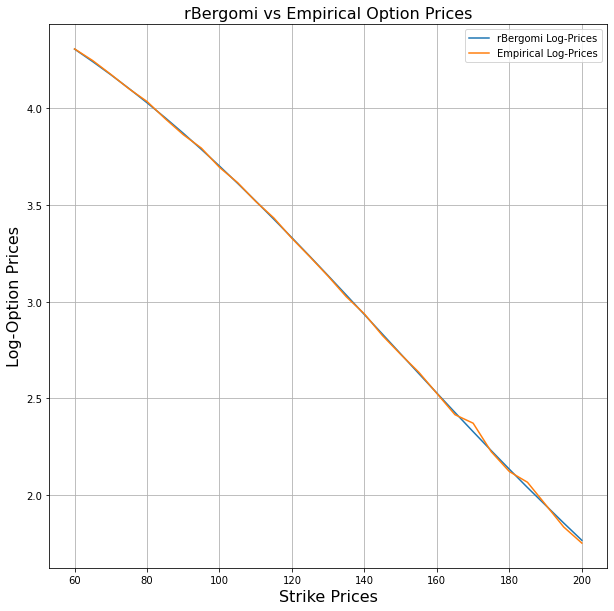

In [16]:
"""
Plotting Log-Option Prices: rBergomi prices VS Last Empirical trades
Also, we price illiquid (newly priced) and imaginary options  

"""


plot, axes = plt.subplots(figsize=(10,10))
axes.plot(df_last_mat["Strike"].values, np.log(np.squeeze(c0)), label="rBergomi Log-Prices")
axes.plot(df_last_mat["Strike"].values, np.log(df_last_mat["Last Price"].values), label="Empirical Log-Prices")
#axes.plot(strikes[:-2], np.log(c0_not_clean[:-2]), "*", c="red", label="Illiquid rBergomi Priced Options")
#axes.plot(strikes[-2:], np.log(c0_not_clean[-2:]), "*", c="magenta", label="Imaginary Option Contracts")
#axes.plot(strikes[:-2], np.log(df_last_mat_not_clean["Last Price"].values), "--", c="black", alpha=0.45, label ="Illiquid Options Old Price")
#axes.plot(strike, np.log(test), label="BlackScholes Pricing")
axes.legend()
axes.set_xlabel(r'Strike Prices', fontsize=16)
axes.set_ylabel(r'Log-Option Prices', fontsize=16)
title = r'rBergomi vs Empirical Option Prices'
axes.set_title(title, fontsize=16)
axes.grid(True)

In [17]:
def rBergomi_vols(df, params, opt_slice=None):
    """
    input:
    df = dataframe with option data
    params = rBergomi parameters
    opt_slice = optimization slice, defining a slice of the df to be used
    
    output:
    rB_list =  rBergomi implied Volatilities
    
    This function is able to price multiple option chains
    """
    
    if opt_slice is not None:
        print("Optimization slice given")
        df = df[df["Maturity"].isin(opt_slice)]
    
    exp_dates_list = df["Tau"].unique()
    
    print(dt.now())
    
    
    FT_list = list()
    call_prices_list = list()
    rB_list = list()
    
    for i, tau in enumerate(exp_dates_list):
        
        df_slice = df[df["Tau"]==tau]
        forward = df_slice["Fwd"].values[0]
        rBivs, c0, rB, FT = rbergomi_s(forward, df_slice["Strike"].values, tau, params)

        FT_list = [*FT_list, *np.squeeze(FT)]
        call_prices_list = [*call_prices_list, *np.squeeze(c0)]
        rB_list = [*rB_list, *np.squeeze(rBivs)]

    print(dt.now())
    print("---")
    return rB_list, df, call_prices_list

In [18]:
"""
# select contracts to be used in optimisation
# Here we select the most crucial contracts to reduce optimization time.
# In order to strike a balance, we want to optimize for both the closest 
# and farthest from maturity.  

"""
expiration_dates = df_cleaned["Maturity"].unique()
mid_point = int(np.round(len(expiration_dates)/2))
optimization_slice = expiration_dates[[-1]]#, 1, mid_point, -2, -1]]
print("The Dates used for optimization are: ")
print(optimization_slice)

The Dates used for optimization are: 
['June 16, 2023']


In [19]:
def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df, call_prices_list = rBergomi_vols(df_cleaned, params, opt_slice=optimization_slice)
    mid_prices = df["Mid"].values
    MSE = np.mean((np.power(np.array(call_prices_list) - np.array(mid_prices), 2)))
    return MSE

In [20]:
init_params = params_2
MSE_init = objective_fun(init_params)
print("The initial MSE for manual selected Params is: {}".format(MSE_init))

Optimization slice given
2021-11-13 16:54:31.810082
2021-11-13 16:54:35.775537
---
The initial MSE for manual selected Params is: 0.004223230189070968


In [21]:
Results = scipy.optimize.minimize(objective_fun, x0=init_params, method="Nelder-Mead", bounds=[[-0.0001,1.,-0.05,0.05],[-0.4999999,5,-1,1]], tol=0.001, options={'maxiter': 500, 'disp': True, 'maxfev': None})

C:\Users\Borsti\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Optimization slice given
2021-11-13 16:55:18.643554
2021-11-13 16:55:22.498240
---
Optimization slice given
2021-11-13 16:55:22.500235
2021-11-13 16:55:26.511544
---
Optimization slice given
2021-11-13 16:55:26.514537
2021-11-13 16:55:30.478931
---
Optimization slice given
2021-11-13 16:55:30.480926
2021-11-13 16:55:34.405614
---
Optimization slice given
2021-11-13 16:55:34.407610
2021-11-13 16:55:38.340088
---
Optimization slice given
2021-11-13 16:55:38.343080
2021-11-13 16:55:42.255225
---
Optimization slice given
2021-11-13 16:55:42.258209
2021-11-13 16:55:46.130971
---
Optimization slice given
2021-11-13 16:55:46.132965
2021-11-13 16:55:50.072426
---
Optimization slice given
2021-11-13 16:55:50.074421
2021-11-13 16:55:53.998750
---
Optimization slice given
2021-11-13 16:55:54.000745
2021-11-13 16:55:57.943704
---
Optimization slice given
2021-11-13 16:55:57.945710
2021-11-13 16:56:01.750519
---
Optimization slice given
2021-11-13 16:56:01.752513
2021-11-13 16:56:05.600290
---
Opti

In [22]:
# Print Results
print("The initial Parameters were: {}".format(init_params))
print("The Nelder-Mead calibrated Parameters are: {}".format(Results.x))
print("The Nelder-Mead calibrated MSE is: {}".format(Results.fun))

# Runtime
start=dt.fromisoformat("2021-11-13 16:55:18.643554")
end=dt.fromisoformat("2021-11-13 17:12:45.852943")
delta_seconds = (end-start).total_seconds()
delta_mins = int(delta_seconds//60)
remaining = np.round(delta_seconds%60, 2)
print("Runtime was: {}:{} Minutes".format(delta_mins, remaining))

The initial Parameters were: (-0.46, 1.7, -0.15, 0.095481)
The Nelder-Mead calibrated Parameters are: [-0.46566168  1.86640719 -0.1520598   0.09554467]
The Nelder-Mead calibrated MSE is: 0.002077388797328591
Runtime was: 17:27.21 Minutes


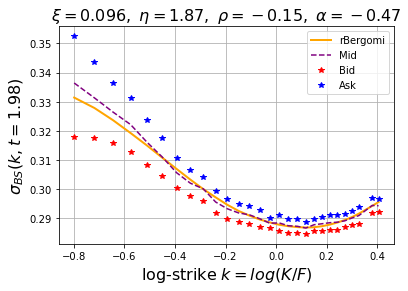

In [23]:
# Calculating log-strike
strike = df_last_mat["Strike"].values
logstrike = df_last_mat["Log Strike"].values

bid_iv_array = df_last_mat["Bid IVs"].values
ask_iv_array = df_last_mat["Ask IVs"].values
mid_vols = df_last_mat["Mid IVs"].values

#forward = df_timeslice["Fwd"].values[0]
tau = df_last_mat["Tau"].values[0]

# Plotting the Fit
rBivs, c0, rB, FT = rbergomi_s(forward, strike, tau, Results.x)


# Graphing
plot, axes = plt.subplots()
axes.plot(logstrike,rBivs, lw=2, c="orange", label="rBergomi")
#axes.plot(log_strike, implied_vols_orig_data, lw=2, alpha=0.6, c="purple", label="Original Data")
axes.plot(logstrike,mid_vols, "--", c="purple", label = "Mid")
axes.plot(logstrike,bid_iv_array, "*", c="r", label = "Bid")
axes.plot(logstrike,ask_iv_array, "*", c="b", label="Ask")
#axes.plot(k_obs[idxT],iv_fit[idxT],'--g',label='Fit')
axes.legend()
axes.set_xlabel(r'log-strike $k=log(K/F)$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

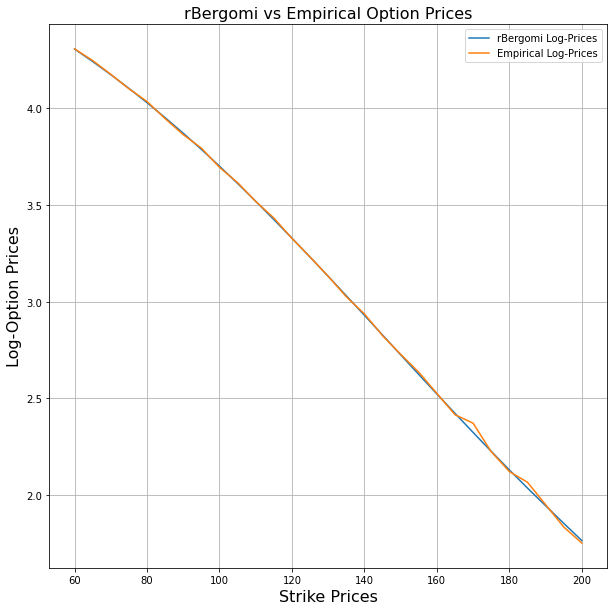

In [24]:
plot, axes = plt.subplots(figsize=(10,10))
axes.plot(df_last_mat["Strike"].values, np.log(np.squeeze(c0)), label="rBergomi Log-Prices")
axes.plot(df_last_mat["Strike"].values, np.log(df_last_mat["Last Price"].values), label="Empirical Log-Prices")
#axes.plot(strikes[:-2], np.log(c0_not_clean[:-2]), "*", c="red", label="Illiquid rBergomi Priced Options")
#axes.plot(strikes[-2:], np.log(c0_not_clean[-2:]), "*", c="magenta", label="Imaginary Option Contracts")
#axes.plot(strikes[:-2], np.log(df_last_mat_not_clean["Last Price"].values), "--", c="black", alpha=0.45, label ="Illiquid Options Old Price")
#axes.plot(strike, np.log(test), label="BlackScholes Pricing")
axes.legend()
axes.set_xlabel(r'Strike Prices', fontsize=16)
axes.set_ylabel(r'Log-Option Prices', fontsize=16)
title = r'rBergomi vs Empirical Option Prices'
axes.set_title(title, fontsize=16)
axes.grid(True)

# Calibration to Full Surface via Slice

In [25]:
import datetime as datetime
from datetime import datetime as dt
# select contracts to be used in optimisation
# Here we select the most crucial contracts to reduce optimization time.
# In order to strike a balance, we want to optimize for both the closest 
# and farthest from maturity.  
expiration_dates = df_cleaned["Maturity"].unique()
mid_point = int(np.round(len(expiration_dates)/2))
optimization_slice = expiration_dates[[0, 2, 5, 12, -1]]#, 1, mid_point, -2, -1]]
print("The Dates used for optimization are: ")
print(optimization_slice)

The Dates used for optimization are: 
['July 2, 2021' 'July 16, 2021' 'August 20, 2021' 'September 16, 2022'
 'June 16, 2023']


In [30]:
"""
This here is the MSE for the full vola surface, using the initial parameters
"""

def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df, call_prices_list = rBergomi_vols(df_cleaned, params, opt_slice=optimization_slice)
    mid_prices = df["Mid"].values
    MSE = np.mean((np.power(np.array(call_prices_list) - np.array(mid_prices), 2)))
    return MSE

In [31]:
Results_NM_surface = scipy.optimize.minimize(objective_fun, x0=init_params, method="Nelder-Mead", bounds=[[-0.0001,1.,-0.05,0.05],[-0.5,5,-1,1]], tol=0.001, options={'maxiter': 500, 'disp': True, 'maxfev': None})

Optimization slice given
2021-11-13 17:35:02.896824
2021-11-13 17:35:10.137939
---
Optimization slice given
2021-11-13 17:35:10.142926
2021-11-13 17:35:17.314712
---
Optimization slice given
2021-11-13 17:35:17.319661
2021-11-13 17:35:24.765739
---
Optimization slice given
2021-11-13 17:35:24.771762
2021-11-13 17:35:31.825922
---
Optimization slice given
2021-11-13 17:35:31.831836
2021-11-13 17:35:39.125402
---
Optimization slice given
2021-11-13 17:35:39.130426
2021-11-13 17:35:46.217396
---
Optimization slice given
2021-11-13 17:35:46.224374
2021-11-13 17:35:53.397756
---
Optimization slice given
2021-11-13 17:35:53.402676
2021-11-13 17:36:00.417242
---
Optimization slice given
2021-11-13 17:36:00.422233
2021-11-13 17:36:07.700692
---
Optimization slice given
2021-11-13 17:36:07.705679
2021-11-13 17:36:15.001227
---
Optimization slice given
2021-11-13 17:36:15.006214
2021-11-13 17:36:22.104423
---
Optimization slice given
2021-11-13 17:36:22.109439
2021-11-13 17:36:29.128704
---
Opti

C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\rbergomi.py:31: RuntimeWarning: covariance is not positive-semidefinite.
  return rng(self.e, self.c, (self.N, self.s))
C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\rbergomi.py:64: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt(2 * self.a + 1) * (Y1 + Y2)
C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\rbergomi.py:89: RuntimeWarning: divide by zero encountered in power
  V = xi * np.exp(eta * Y - 0.5 * eta**2 * t**(2 * a + 1))
C:\Users\Borsti\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


2021-11-13 17:45:20.817377
---
Optimization slice given
2021-11-13 17:45:20.821366
2021-11-13 17:45:28.717475
---
Optimization slice given
2021-11-13 17:45:28.722462
2021-11-13 17:45:35.655913
---
Optimization slice given
2021-11-13 17:45:35.660900
2021-11-13 17:45:42.516559
---
Optimization slice given
2021-11-13 17:45:42.522544
2021-11-13 17:45:49.481993
---
Optimization slice given
2021-11-13 17:45:49.487944
2021-11-13 17:45:56.317399
---
Optimization slice given
2021-11-13 17:45:56.322391
2021-11-13 17:46:03.224918
---
Optimization slice given
2021-11-13 17:46:03.229905
2021-11-13 17:46:10.060845
---
Optimization slice given
2021-11-13 17:46:10.064835
2021-11-13 17:46:17.034189
---
Optimization slice given
2021-11-13 17:46:17.039233
2021-11-13 17:46:24.910396
---
Optimization slice given
2021-11-13 17:46:24.915372
2021-11-13 17:46:31.799439
---
Optimization slice given
2021-11-13 17:46:31.804440
2021-11-13 17:46:38.591269
---
Optimization slice given
2021-11-13 17:46:38.596257
2021

In [32]:
# Print Results
print("The initial Parameters were: {}".format(init_params))
print("The Nelder-Mead calibrated Parameters are: {}".format(Results_NM_surface.x))
print("The Nelder-Mead calibrated MSE is: {}".format(Results_NM_surface.fun))

# Runtime
start=dt.fromisoformat("2021-11-13 17:35:02.896824")
end=dt.fromisoformat("2021-11-13 18:24:18.657670")
delta_seconds = (end-start).total_seconds()
delta_mins = int(delta_seconds//60)
remaining = np.round(delta_seconds%60, 2)
print("Runtime was: {}:{} Minutes".format(delta_mins, remaining))

The initial Parameters were: (-0.46, 1.7, -0.15, 0.095481)
The Nelder-Mead calibrated Parameters are: [-0.49999909  3.14690818 -0.1521208   0.106366  ]
The Nelder-Mead calibrated MSE is: 0.05617944843845571
Runtime was: 49:15.76 Minutes


In [35]:
# FULL SURFACE MSE

"""
This here is the MSE for the full vola surface, using the initial parameters
"""

def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df, call_prices_list = rBergomi_vols(df_cleaned, params, opt_slice=None)
    mid_prices = df["Mid"].values
    MSE = np.mean((np.power(np.array(call_prices_list) - np.array(mid_prices), 2)))
    return MSE
objective_fun(Results_NM_surface.x)

2021-11-13 21:22:07.177989
2021-11-13 21:22:27.323058
---


0.18621292990957516

In [33]:
Results_NM_surface.x

array([-0.49999909,  3.14690818, -0.1521208 ,  0.106366  ])

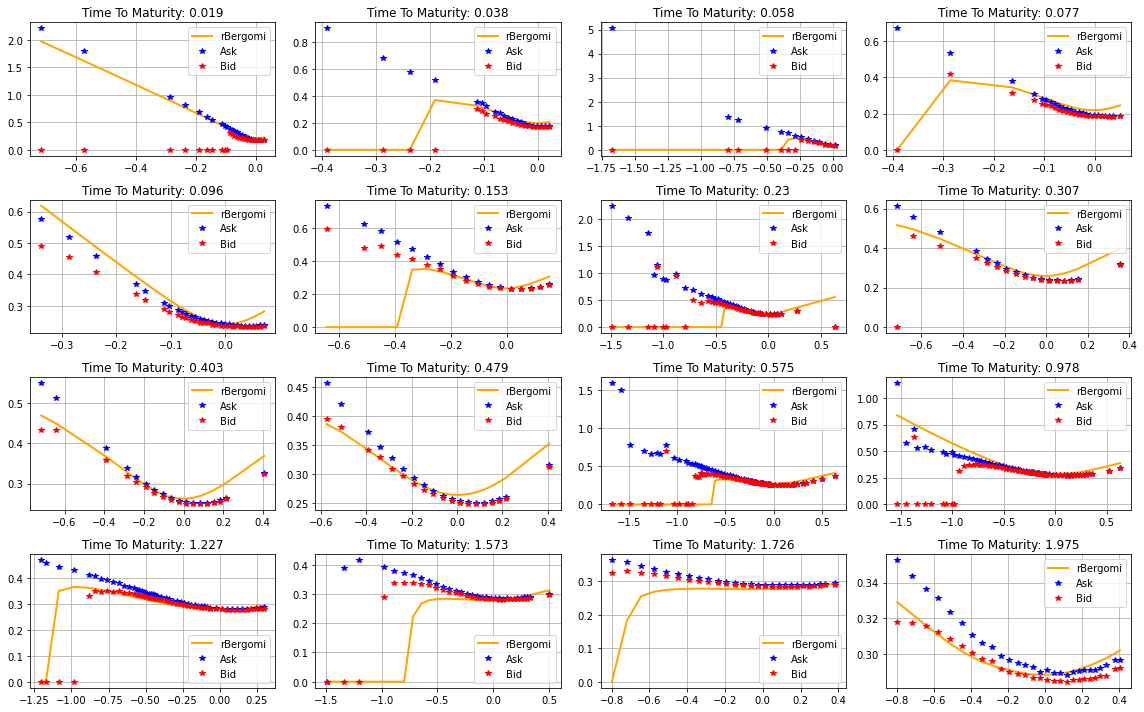

In [34]:
best_params = -0.49999909,  3.14690818, -0.1521208 ,  0.106366  
# Fit For Best Params
plt.figure(figsize=(16,10))
j = -1
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    j = j + 1
    plt.subplot(4,4,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_cleaned[df_cleaned["Tau"] == tau]
    
    # Calculating Forward Price
    forward = forward_price(spot, div, r, tau)
    
    # calc rBergomi IVs
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, best_params)
    
    # Calculating log-strike
    logstrike = np.log(df_timeslice["Strike"].values/forward)
    
    # Calculating bid/ask bounds
    ask_iv_vals = vec_bsinv(df_timeslice["Ask"].values, forward, df_timeslice["Strike"].values, tau)
    bid_iv_vals = vec_bsinv(df_timeslice["Bid"].values, forward, df_timeslice["Strike"].values, tau)
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()